# Example Predictor: SIR Rollout Predictor

This example contains basic functionality for training and evaluating a linear predictor that rolls out predictions day-by-day.

First, a training data set is created from historical case and npi data.

Second, a linear model is trained to predict future cases from prior case data along with prior and future npi data.
The model is an off-the-shelf sklearn Lasso model, that uses a positive weight constraint to enforce the assumption that increased npis has a negative correlation with future cases.

Third, a sample evaluation set is created, and the predictor is applied to this evaluation set to produce prediction results in the correct format.

## Training

In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import sys, os
#from os.path import pardir, sep 
sys.path.insert(1,'/'+os.path.join(*os.getcwd().split('/')[:-2])+'/utils')
from custom_models import SIR_parfinder
from df_preparation import *

### Copy the data locally

In [2]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

In [3]:
import os
import urllib.request
if not os.path.exists('data'):
    os.mkdir('data')
#urllib.request.urlretrieve(DATA_URL, DATA_FILE)

In [4]:
# Load historical data from local file
df = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [5]:
df.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDispla

In [6]:
# For testing, restrict training data to that before a hypothetical predictor submission date
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-07-31")
df = df[df.Date <= HYPOTHETICAL_SUBMISSION_DATE]

In [7]:
df=create_dataset(df)

In [8]:
# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']
# Columns we care just about the last value (usually it's always the same value for most of them)
adj_cols_fixed=[ 'PastCases','Population',
       'Population Density (# per km2)',
       'Urban population (% of total population)',
       'Population ages 65 and above (% of total population)',
       'GDP per capita (current US$)', 'Obesity Rate (%)', 'Cancer Rate (%)',
       'Share of Deaths from Smoking (%)', 'Pneumonia Death Rate (per 100K)',
       'Share of Deaths from Air Pollution (%)',
       'CO2 emissions (metric tons per capita)',
       'Air transport (# carrier departures worldwide)']

# Columns we would like to include for the last nb_lookback days
adj_cols_time=['TemperatureC']


cases_col = ['NewCases']
npi_cols = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']


In [9]:
# Fill also missing CONFIRMED case values by interpolation and setting NaNs to 0
df.update(df.groupby('GeoID').ConfirmedCases.apply(
    lambda group: group.interpolate()).fillna(0))

In [10]:
df=add_population_data(df)
df=add_temp(df)

In [11]:
df['PastCases']=df.ConfirmedCases.values

In [12]:
df.columns

Index(['CountryName', 'CountryCode', 'Population',
       'Population Density (# per km2)',
       'Urban population (% of total population)',
       'Population ages 65 and above (% of total population)',
       'GDP per capita (current US$)', 'Obesity Rate (%)', 'Cancer Rate (%)',
       'Share of Deaths from Smoking (%)', 'Pneumonia Death Rate (per 100K)',
       'Share of Deaths from Air Pollution (%)',
       'CO2 emissions (metric tons per capita)',
       'Air transport (# carrier departures worldwide)', 'RegionName',
       'RegionCode', 'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_

In [13]:
df.count().tail(20)

H6_Flag                              20165
H7_Vaccination policy                31311
H7_Flag                                  0
M1_Wildcard                              0
ConfirmedCases                       42600
ConfirmedDeaths                      36949
StringencyIndex                      42386
StringencyIndexForDisplay            42386
StringencyLegacyIndex                42386
StringencyLegacyIndexForDisplay      42386
GovernmentResponseIndex              42380
GovernmentResponseIndexForDisplay    42380
ContainmentHealthIndex               42385
ContainmentHealthIndexForDisplay     42385
EconomicSupportIndex                 36844
EconomicSupportIndexForDisplay       36844
GeoID                                42600
NewCases                             42600
TemperatureC                         42600
PastCases                            42600
dtype: int64

In [14]:
# Keep only columns of interest
df = df[id_cols+ cases_col  +adj_cols_fixed+ adj_cols_time+ npi_cols]

In [15]:
df.count()

CountryName                                             42600
RegionName                                              16827
GeoID                                                   42600
Date                                                    42600
NewCases                                                42600
PastCases                                               42600
Population                                              42600
Population Density (# per km2)                          42600
Urban population (% of total population)                42600
Population ages 65 and above (% of total population)    42600
GDP per capita (current US$)                            42600
Obesity Rate (%)                                        42600
Cancer Rate (%)                                         42600
Share of Deaths from Smoking (%)                        42600
Pneumonia Death Rate (per 100K)                         42600
Share of Deaths from Air Pollution (%)                  42600
CO2 emis

In [16]:
df.loc[df.NewCases<0,'NewCases']=0

In [17]:
lookback_days=30
infection_days=7

X_samples, y_samples= skl_format(df,cases_col,adj_cols_fixed,adj_cols_time,npi_cols,lookback_days)
print(X_samples.shape)
print(y_samples.shape)

(36400, 433)
(36400,)


In [44]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_samples,
                                                    y_samples,
                                                    test_size=0.2,
                                                    random_state=301)

In [45]:
Sreg=SIR_parfinder(infection_days=infection_days,fit_days=15,nprocs=26)
Sreg.fit(X_train)

100%|██████████| 260/260 [00:12<00:00, 20.21it/s]


SIR_parfinder(nprocs=26)

In [38]:
i=random.randint(0,X_train.shape[0])

X_i=X_train[i,:]
pars=Sreg.labels_[i]
print(Sreg.row_initial_conditions(X_i))
print(pars)
if not np.isnan(pars[0]):
    y_pred_cases=Sreg.row_predict(X_i,pars)
    plt.plot(Sreg.time_integ[1:],Sreg.row_observed_cases(X_i),label='observed')
    plt.plot(Sreg.time_integ[1:],y_pred_cases,label='pred')
    plt.legend()

(5421241.0, (5420841.0, 0.0, 400.0, 400.0))
[nan nan]


(18383955.0, (18383840.0, 9.0, 106.0, 106.0))
[0.31783887 0.27958483]


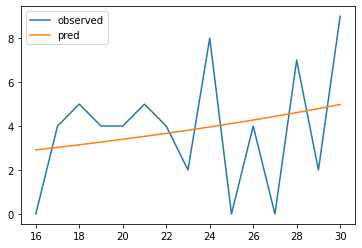

In [49]:
i=random.randint(0,X_test.shape[0])

X_i=X_test[i,:]
pars=Sreg.predict(X_i.reshape(-1,1))
print(Sreg.row_initial_conditions(X_i))
print(pars)
if not np.isnan(pars[0]):
    y_pred_cases=Sreg.row_predict(X_i,pars)
    plt.plot(Sreg.time_integ[1:],Sreg.row_observed_cases(X_i),label='observed')
    plt.plot(Sreg.time_integ[1:],y_pred_cases,label='pred')
    plt.legend()

## Ground truth MAE

In [51]:
y_pred=[Sreg.row_predict(X_samples[i,:])]

array([2.91594667, 3.02964765, 3.1478191 , 3.27063952, 3.39816531,
       3.53061487, 3.66821387, 3.81118801, 3.95976293, 4.11416434,
       4.27461789, 4.44134926, 4.61458414, 4.79454819, 4.98146709])